In [1]:
def speak(text):
    from IPython.display import Javascript as js, clear_output
    # Escape single quotes
    text = text.replace("'", r"\'")
    display(js(f'''
    if(window.speechSynthesis) {{
        var synth = window.speechSynthesis;
        synth.speak(new window.SpeechSynthesisUtterance('{text}'));
    }}
    '''))
    # Clear the JS so that the notebook doesn't speak again when reopened/refreshed
    clear_output(False)

In [2]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Loading your IBM Q account(s)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research', group='iserc-1', project='main')

In [3]:
from qiskit import *

In [4]:
from matplotlib import pyplot as plt

In [5]:
backend = provider.get_backend('ibmq_armonk')

In [163]:
from qiskit import *
from qiskit.pulse import *
from qiskit.tools.monitor import job_monitor

qubit = 0
back_config = backend.configuration()
inst_sched_map = backend.defaults().instruction_schedule_map
meas_map_idx = None
for i, measure_group in enumerate(back_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"
measure = inst_sched_map.get('measure', qubits=back_config.meas_map[qubit])

pulse_sigma = 80
pulse_duration = (4*pulse_sigma)-((4*pulse_sigma)%16)
drive_chan = DriveChannel(0)

def create_cal_circuits(amp):
    sched = Schedule()
    sched+=Play(Gaussian(duration=pulse_duration, sigma=pulse_sigma, amp=amp), drive_chan)
    measure = inst_sched_map.get('measure', qubits=[qubit])
    sched+=measure << sched.duration
    return sched

default_qubit_freq = backend.defaults().qubit_freq_est[0]
freq_list = np.linspace(default_qubit_freq-(20*1e+6), default_qubit_freq+(20*1e+6), 75)
sched_list = [create_cal_circuits(0.4)]*75
sweep_exp = assemble(sched_list, backend=backend, meas_level=1, meas_return='avg', shots=1024, schedule_los = [{drive_chan: freq} for freq in freq_list])
sweep_job = backend.run(sweep_exp)
job_monitor(sweep_job)
sweep_result = sweep_job.result()
sweep_values = []
for i in range(len(sweep_result.results)):
    res = sweep_result.get_memory(i)*1e-14
    sweep_values.append(res[qubit])
scale_factor = 1e+9
freq_list_scaled = freq_list/scale_factor

Job Status: job has successfully run


In [170]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

fit_params, y_fit = fit_function(freq_list_scaled,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [5, 4.975, 1, 19] # initial parameters for curve_fit
                                )

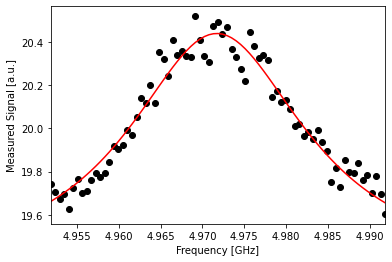

In [171]:
plt.scatter(freq_list_scaled, np.real(sweep_values), color='black')
plt.plot(freq_list_scaled, y_fit, color='red')
plt.xlim([min(freq_list_scaled), max(freq_list_scaled)])
# plt.ylim([-7,0])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

_, qubit_freq_new, _, _ = fit_params
qubit_freq_ground = qubit_freq_new*scale_factor

In [165]:
speak("The test program is done.")

In [172]:
print(f"The new qubit frequency is : {qubit_freq_ground} Hz")

The new qubit frequency is : 4971715960.962498 Hz


In [173]:
#### Moving on to the Rabi experiments for 0->1 transition.

amp_list = np.linspace(0, 1.0, 75)
rabi_sched_list = [create_cal_circuits(amp) for amp in amp_list]
rabi_exp = assemble(rabi_sched_list, backend=backend, meas_level=1, meas_return='avg', shots=1024, schedule_los=[{drive_chan: qubit_freq_ground}]*len(rabi_sched_list))

rabi_job = backend.run(rabi_exp)
job_monitor(rabi_job)
rabi_results = rabi_job.result()
scale_factor = 1e-14
rabi_values = []
for i in range(75):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

def baseline_remove(values):
    return np.array(values) - np.mean(values)

rabi_values = np.real(baseline_remove(rabi_values))

Job Status: job has successfully run


In [184]:
fit_params, y_fit = fit_function(amp_list,
                             rabi_values, 
                             lambda x, A, B, drive_period, phi: (A*np.sin(2*np.pi*x/drive_period - phi) + B),
                             [0.6, 0.1, 1.6, 0])
drive_period = fit_params[2]
pi_amp_ground = drive_period/2

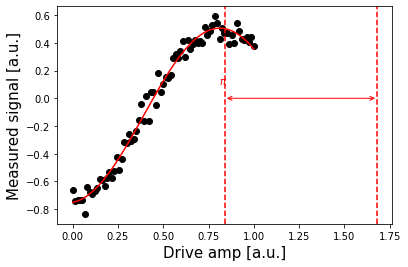

In [185]:
plt.scatter(amp_list, rabi_values, color='black')
plt.plot(amp_list, y_fit, color='red')
plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [186]:
print(f"The calibrated pi amp is : {pi_amp_ground}")

The calibrated pi amp is : 0.8397881284352938


In [187]:
def get_pi_pulse_ground():
    try:
        pulse = pulse_lib.gaussian(duration=pulse_duration, sigma=pulse_sigma, amp=pi_amp_ground)
    except ValueError:
        raise ValueError("pi_amp_ground not defined. Please compute pi_amp_ground first")
    except Exception as err:
        traceback.print_exc()
    return pulse

def get_zero_sched():
    zero_sched = Schedule()
    zero_sched += measure
    return zero_sched

def get_one_sched():
    one_sched = Schedule()
    one_sched += Play(get_pi_pulse_ground(), drive_chan)
    one_sched += measure << one_sched.duration
    return one_sched

def IQ_plot( zero_data, one_data):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')

    x_min = np.min(np.append(np.real(zero_data), np.real(one_data)))-5
    x_max = np.max(np.append(np.real(zero_data), np.real(one_data)))+5
    y_min = np.min(np.append(np.imag(zero_data), np.imag(one_data)))-5
    y_max = np.max(np.append(np.imag(zero_data), np.imag(one_data)))+5

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1 discrimination", fontsize=15)
    return x_min, x_max, y_min, y_max

def reshape_complex_vec( vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

def separatrixPlot( lda, x_min, x_max, y_min, y_max, shots):
    nx, ny = shots, shots
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='black')

In [190]:
measure = inst_sched_map.get('measure', qubits=[qubit])
one_sched = get_one_sched()
exp = assemble(one_sched, backend=backend, meas_level=2, 
               meas_return='single', shots=1024, schedule_los=[{drive_chan: qubit_freq_ground}])
qjob = backend.run(exp)
job_monitor(qjob)

Job Status: job has successfully run


In [191]:
print(qjob.result().get_counts())

{'0': 114, '1': 910}


In [194]:
# zero_sched = get_zero_sched()
# one_sched = get_one_sched()
# IQ_exp = assemble([zero_sched, one_sched], backend=backend, 
#                   meas_level=1, meas_return='single', shots=1024, 
#                   schedule_los=[{drive_chan: qubit_freq_ground}]*2
#                  )
IQ_exp_0 = assemble([zero_sched], backend=backend, 
                  meas_level=1, meas_return='single', shots=1024, 
                  schedule_los=[{drive_chan: qubit_freq_ground}]
                 )
IQ_job_0 = backend.run(IQ_exp_0)
print('Running job 1')
job_monitor(IQ_job_0)

IQ_exp_1 = assemble([one_sched], backend=backend, 
                  meas_level=1, meas_return='single', shots=1024, 
                  schedule_los=[{drive_chan: qubit_freq_ground}]
                 )
IQ_job_1 = backend.run(IQ_exp_1)
print('Running job 2')
job_monitor(IQ_job_1)

Running job 1
Job Status: job has successfully run
Running job 2
Job Status: job has successfully run
Running job 3
Job Status: job has successfully run
Running job 4
Job Status: job has successfully run


In [ ]:
new_one_sched = Schedule()
new_one_sched += measure << pulse_duration
IQ_exp_11 = assemble([new_one_sched], backend=backend, 
                  meas_level=1, meas_return='single', shots=1024, 
                  schedule_los=[{drive_chan: qubit_freq_ground}]
                 )
IQ_job_11 = backend.run(IQ_exp_11)
print('Running job 3')
job_monitor(IQ_job_11)

new_one_sched_2 = Schedule()
new_one_sched_2 += measure << 2*pulse_duration
IQ_exp_12 = assemble([new_one_sched_2], backend=backend, 
                  meas_level=1, meas_return='single', shots=1024, 
                  schedule_los=[{drive_chan: qubit_freq_ground}]
                 )
IQ_job_12 = backend.run(IQ_exp_12)
print('Running job 4')
job_monitor(IQ_job_12)

In [195]:
data_0 = get_job_data(IQ_job_0, average=False)
data_1 = get_job_data(IQ_job_1, average=False)
data_11 = get_job_data(IQ_job_11, average=False)
data_12 = get_job_data(IQ_job_12, average=False)

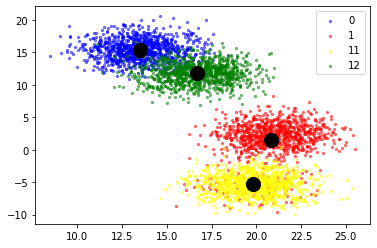

In [198]:
plt.scatter(np.real(data_0[0]), np.imag(data_0[0]), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label=r'0')
plt.scatter(np.real(data_1[0]), np.imag(data_1[0]), 
                s=5, cmap='viridis', c='red', alpha=0.5, label=r'1')
plt.scatter(np.real(data_11[0]), np.imag(data_11[0]), 
                s=5, cmap='viridis', c='yellow', alpha=0.5, label=r'11')
plt.scatter(np.real(data_12[0]), np.imag(data_12[0]), 
                s=5, cmap='viridis', c='green', alpha=0.5, label=r'12')

mean_0 = np.mean(data_0[0])
mean_1 = np.mean(data_1[0])
mean_11 = np.mean(data_11[0])
mean_12 = np.mean(data_12[0])

plt.scatter(np.real(mean_0), np.imag(mean_0), 
            s=200, cmap='viridis', c='black',alpha=1.0)
plt.scatter(np.real(mean_1), np.imag(mean_1), 
            s=200, cmap='viridis', c='black',alpha=1.0)
plt.scatter(np.real(mean_11), np.imag(mean_11), 
            s=200, cmap='viridis', c='black',alpha=1.0)
plt.scatter(np.real(mean_12), np.imag(mean_12), 
            s=200, cmap='viridis', c='black',alpha=1.0)
plt.legend()

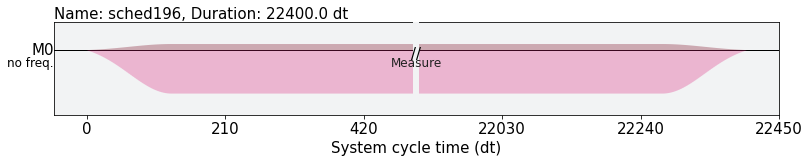

In [199]:
zero_sched.draw()  # 0

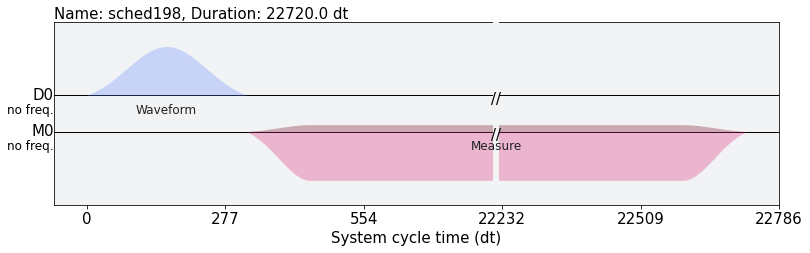

In [200]:
one_sched.draw() # 1

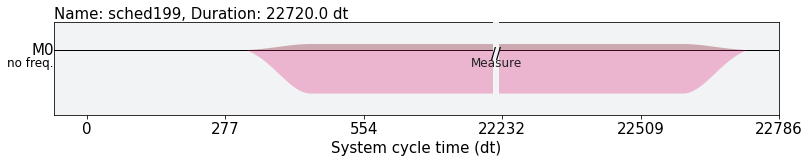

In [201]:
new_one_sched.draw() # 11

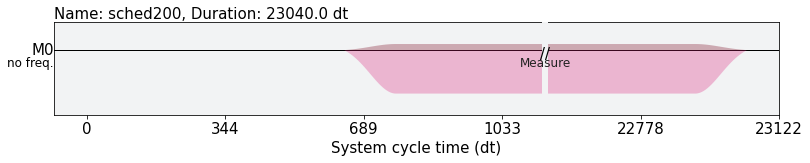

In [202]:
new_one_sched_2.draw()  # 12

In [148]:
def get_job_data(job, average):
    scale_factor = 1e-14
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

In [ ]:
IQ_data = get_job_data(IQ_job, average=False)
zero_data = IQ_data[0]
one_data = IQ_data[1]
# zero_data = get_job_data(IQ_job_0, average=False)
# one_data = get_job_data(IQ_job_1, average=False)

The discriminator plot for 0-1-2 discrimination.
The accuracy score of the discriminator is:  0.919921875


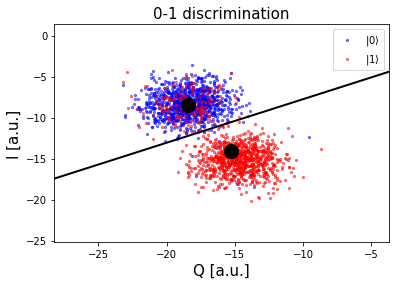

In [150]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

print("The discriminator plot for 0-1-2 discrimination.")
x_min, x_max, y_min, y_max = IQ_plot(zero_data, one_data)
# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data) 

IQ_data = np.concatenate((zero_data_reshaped, one_data_reshaped))

# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(1024) # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(1024)))
# state_012 = np.concatenate((state_012, 2*np.ones(1024)))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_data, state_012, test_size=0.5)
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)
score_012 = LDA_012.score(IQ_012_test, state_012_test)
print('The accuracy score of the discriminator is: ', score_012)
# # _state_discriminator_012 = LDA_012
# if visual:
#             IQ_plot(zero_data, one_data, two_data)
separatrixPlot(LDA_012, x_min, x_max, y_min, y_max, 1024)

In [161]:
new_exp_1 = assemble([new_one_sched], backend=backend, 
                  meas_level=2, meas_return='single', shots=1024, 
                  schedule_los=[{drive_chan: qubit_freq_ground}]
                 )
new_job_1 = backend.run(new_exp_1)
job_monitor(new_job_1)

Job Status: job has successfully run


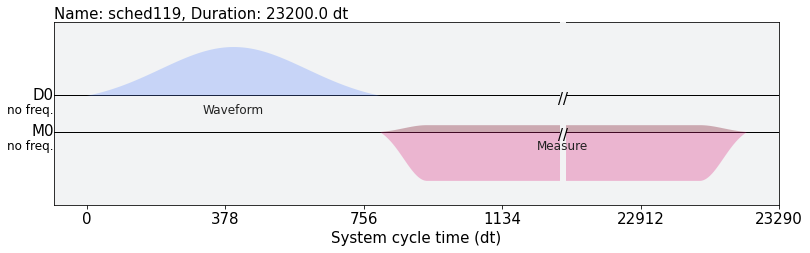

In [160]:
new_one_sched.draw()

In [162]:
print(new_job_1.result().get_counts())

{'0': 176, '1': 848}


(-0.20285506142208032, 23.94747908079616, 3.9369075515392, 41.89840763731968)

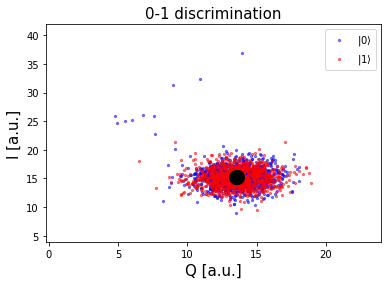

In [82]:
IQ_plot(new_data_0[0], new_data_1[0])

(3.1518291373260805, 24.75751930806272, 4.1992394563584, 40.47351197155328)

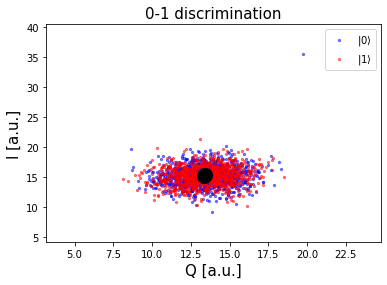

In [74]:
new_results = new_job.result()
new_data = get_job_data(new_job, average=False)
new_0_data = new_data[0]
new_1_data = new_data[1]

IQ_plot(new_0_data, new_1_data)

In [ ]:
diff_one_sched = Schedule()
diff_one_sched += Play(Gaussian(duration=pulse_duration, sigma=pulse_sigma, amp=0), drive_chan)
diff_one_sched += measure

In [65]:
print(*np.around(zero_data[:10],2), sep='\n')

(-19.09-9.23j)
(-18.07-7.45j)
(-18.36-10.46j)
(-22.34-5.47j)
(-18.51-6.95j)
(-19.8-10.39j)
(-11.51-15.74j)
(-16.93-8.95j)
(-20-9.44j)
(-19.21-8.94j)


The discriminator plot for 0-1-2 discrimination.
The accuracy score of the discriminator is:  0.998046875


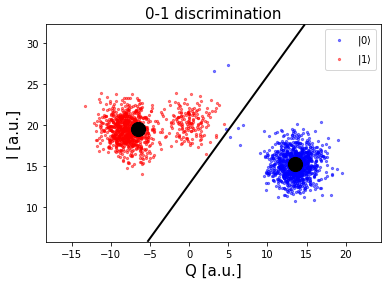

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

print("The discriminator plot for 0-1-2 discrimination.")
x_min, x_max, y_min, y_max = IQ_plot(zero_data[0], one_data[0])
# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data[0])
one_data_reshaped = reshape_complex_vec(one_data[0]) 

IQ_data = np.concatenate((zero_data_reshaped, one_data_reshaped))

# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(1024) # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(1024)))
# state_012 = np.concatenate((state_012, 2*np.ones(1024)))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_data, state_012, test_size=0.5)
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)
score_012 = LDA_012.score(IQ_012_test, state_012_test)
print('The accuracy score of the discriminator is: ', score_012)
# _state_discriminator_012 = LDA_012
# if visual:
#             IQ_plot(zero_data, one_data, two_data)
separatrixPlot(LDA_012, x_min, x_max, y_min, y_max, 1024)

In [ ]:
speak('The test is over. Check it out.')

In [47]:
from qiskit.pulse import *
import qiskit.pulse.library as pulse_lib
from scipy.signal import find_peaks

In [19]:
### Next, going on to test the function to calibrate the 1->2 transition frequency

def apply_sideband(pulse, frequency):
    t_samples = np.linspace(0, dt*pulse_duration, pulse_duration)
    sine_pulse = np.sin(2*np.pi*(frequency-qubit_freq_ground)*t_samples)
    sideband_pulse = Waveform(np.multiply(np.real(pulse.samples), sine_pulse), name='sideband_pulse')
    return sideband_pulse

def get_job_data(job, average):
    scale_factor = 1e-14
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average:
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else:
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def rel_maxima(freqs, output_data, height):
    peaks, _ = find_peaks(output_data, height)
    return freqs[peaks]

def create_cal_circuit_excited(base_pulse, freq):
    sched = Schedule()
    sched += Play(Gaussian(duration=pulse_duration, sigma=pulse_sigma, amp=pi_amp_ground), drive_chan)
    sched += Play(apply_sideband(base_pulse, freq), drive_chan)
    measure = inst_sched_map.get('measure', qubits=[qubit])
    sched += measure << sched.duration
    return sched

In [20]:
dt = backend.configuration().dt

In [21]:
base_pulse = pulse_lib.gaussian(duration=pulse_duration, sigma=pulse_sigma, amp=0.3)
sched_list = []
freq_list = qubit_freq_ground + np.linspace(-400*1e+6, 30*1e+6, 75)
for freq in freq_list:
    sched_list.append(create_cal_circuit_excited(base_pulse, freq))
excited_sweep_exp = assemble(sched_list, backend=backend, 
                             meas_level=1, meas_return='avg', shots=1024, 
                             schedule_los=[{drive_chan: qubit_freq_ground}]*75
                            )
excited_sweep_job = backend.run(excited_sweep_exp)
job_monitor(excited_sweep_job)
excited_sweep_data = get_job_data(excited_sweep_job, average=True)

Job Status: job has successfully run


In [22]:
excited_sweep_freqs = freq_list

/home/tharrma/research_qiskit/lib/python3.7/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


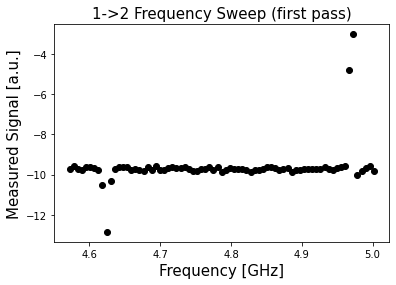

In [23]:
plt.scatter(excited_sweep_freqs/1e+9, excited_sweep_data, color='black')
# plt.xlim([min(excited_sweep_freqs/1e+9)+0.01, max(excited_sweep_freqs/1e+9)]) # ignore min point (is off)
# plt.ylim(-21,-20.5)
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (first pass)", fontsize=15)
plt.show()
approx_12_freq = rel_maxima(freq_list, np.real(excited_sweep_data), 10)

In [24]:
speak("The test program is done.")

In [121]:
approx_12_freq = rel_maxima(freq_list, np.real(excited_sweep_data), 10)

array([4.57772472e+09, 4.58934634e+09, 4.60096797e+09, 4.62421121e+09,
       4.65326526e+09, 4.67069770e+09, 4.69394094e+09, 4.71137337e+09,
       4.73461661e+09, 4.74623824e+09, 4.75785986e+09, 4.77529229e+09,
       4.78691391e+09, 4.80434634e+09, 4.82177878e+09, 4.83921121e+09,
       4.85083283e+09, 4.86245445e+09, 4.87988688e+09, 4.89150851e+09,
       4.90313013e+09, 4.91475175e+09, 4.93218418e+09, 4.94961661e+09,
       4.97285986e+09, 4.98448148e+09, 4.99610310e+09])

In [ ]:
#### This is to find the refined frequency of the second excited state.

refined_freq_list = approx_12_freq + np.linspace(-20*1e+6, 20*1e+6, 75)
refined_sched_list = []
for freq in refine_freq_list:
    sched_list.append(create_cal_circuit_excited(base_pulse, freq))
refined_sweep_exp = assemble(refined_sched_list, backend=backend, 
                             meas_level=1, meas_return='avg', shots=1024, 
                             schedule_los=[{drive_chan: qubit_freq_ground}]*75
                            )
refined_sweep_job = backend.run(refined_sweep_exp)
refined_sweep_data = get_job_data(refined_sweep_job, average=True)
# do fit in Hz
(refined_sweep_fit_params, 
 refined_sweep_y_fit) = fit_function(refined_freq_list,
                                     refined_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-12, 4.625*1e+9, 0.05*1e+9, 3*1e+9] # initial parameters for curve_fit
                                     )

In [ ]:
plt.scatter(refined_excited_sweep_freqs/1e+9, refined_excited_freq_sweep_data, color='black')
plt.plot(refined_excited_sweep_freqs/1e+9, refined_excited_sweep_y_fit, color='red')
plt.xlim([min(refined_excited_sweep_freqs/1e+9), max(refined_excited_sweep_freqs/1e+9)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()
_, qubit_freq_12, _, _ = refined_sweep_fit_params
qubit_freq_excited = qubit_freq_12